### Resources used in this jupyter notebook
 - This database may contain best data for ML training... [openweathermap.org](https://openweathermap.org/history#historybulk)
 - NOAA actually does have what is called the ISD or [Integrated Surface Data](ftp://ftp.ncdc.noaa.gov/pub/data/noaa/isd-lite/2018/), which has station-by-station hourly files for temp, wind dir, wind speed (but most of cloud cover data is missing)

### Overview
1) Load, clean, organize the following data
 - Temp, wind dir, wind speed hour-by-hour [here](ftp://ftp.ncdc.noaa.gov/pub/data/noaa/isd-lite/2018/)
 - Station metadata from the isd_inventory.txt (or .csv) [here](ftp://ftp.ncdc.noaa.gov/pub/data/noaa)
 - Even more station metadata such as number of datapoints from isd_history.txt (or .csv) [here](ftp://ftp.ncdc.noaa.gov/pub/data/noaa)
2) Plotting resources
 - Geopandas and geoplot [here](http://geopandas.org/gallery/plotting_with_geoplot.html)
 - Quiver plot for wind directional data [here](https://stackoverflow.com/questions/55338556/how-to-overlay-a-quiver-plot-on-a-geodataframe-plot-in-python)
 - Bokeh + geopandas + interactive = [great resource](https://automating-gis-processes.github.io/2016/Lesson5-interactive-map-bokeh.html)

In [1]:
# import libraries and magic
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import re
import geopandas
import requests
import glob
from IPython.display import display

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.rcParams.update({'font.size': 12})

In [2]:
# station IDs + metadata like lat/lon
year = 2015
meta_url = 'ftp://ftp.ncdc.noaa.gov/pub/data/noaa/isd-history.txt'
meta_df = pd.read_fwf(
    meta_url,
    skiprows=22,
    names=[
        'af_station_id',
        'ncdc_station_id',
        'station_name',
        'country_id',
        'airport_id',
        'latitude',
        'longitude',
        'elevation',
        'begin',
        'end'])

# Convert dates to datetime
date_before = dt.datetime(year, 1, 1)
meta_df['begin'] = pd.to_datetime(meta_df['begin'], format='%Y%m%d') # convert to date-time format
meta_df['end'] = pd.to_datetime(meta_df['end'], format='%Y%m%d') #convert to date-time format

# filter on country (canadian stations)
meta_df = meta_df.loc[meta_df['country_id']=='CA']

# filter on date (only those with recent data included)
date_after = dt.datetime(2015, 1, 1)
date_before = dt.datetime(2019, 1, 1)
meta_df = meta_df.loc[(meta_df['begin']<date_after) & (meta_df['end']>date_before)]

# Filter on location (hone in on southern Ontario for now)
lat_lims = [41.628091, 46.698737]
lon_lims = [-83.313449, -74.216769]
meta_df = meta_df.loc[(meta_df['latitude']>lat_lims[0]) & (meta_df['latitude']<lat_lims[1])]
meta_df = meta_df.loc[(meta_df['longitude']>lon_lims[0]) & (meta_df['longitude']<lon_lims[1])]

# get rid of station id 9999
meta_df = meta_df.loc[meta_df['af_station_id']!='999999',:]

# Look at what we've got
display(meta_df.head())
print(meta_df.dtypes)
print('Number of stations in Canada with at least four recent years of data:',len(meta_df))

,af_station_id,ncdc_station_id,station_name,country_id,airport_id,latitude,longitude,elevation,begin,end
15620,710630,99999,OTTAWA CDA RCS ONT,CA,NaN,45.383,-75.717,79.0,1977-07-01,2019-04-22
15811,711610,99999,BROCKVILLE CLIMATE,CA,CTBO,44.633,-75.733,120.0,1993-07-01,2019-04-22
15823,711710,99999,VINELAND STATION RCS O,CA,CXVN,43.183,-79.400,79.0,2004-05-10,2019-04-22
15824,711720,99999,PARRY SOUND CCG ONT,CA,CXPC,45.333,-80.033,176.0,2004-08-03,2019-04-22
15857,711960,99999,PEMBROKE CLIMATE,CA,NaN,45.867,-77.250,162.0,1959-11-17,2019-04-22


af_station_id              object
ncdc_station_id             int64
station_name               object
country_id                 object
airport_id                 object
latitude                  float64
longitude                 float64
elevation                 float64
begin              datetime64[ns]
end                datetime64[ns]
dtype: object
Number of stations in Canada with at least four recent years of data: 70


In [3]:
# required for future auto-conversion of pandas datetime objects for plotting
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.rcParams.update({'font.size': 14})

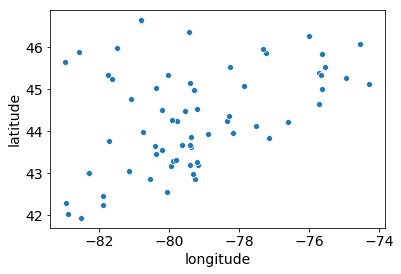

In [4]:
sns.scatterplot(x='longitude',y='latitude',data=meta_df);

In [5]:
# extract list of stations
print(len(meta_df['af_station_id'].value_counts()),'unique af_station_id\'s in dataset')

70 unique af_station_id's in dataset


In [6]:
# figure out what all my files are called
def get_filenames(url, meta_df):
    fndf = pd.read_fwf(url,names = ['a','b','c','d','e','f','g','h','filename'])
    split_fndf = fndf['filename'].str.split('-', expand=True)
    split_fndf.columns = ['a','b','c']
    subset = split_fndf[split_fndf['a'].isin(meta_df['af_station_id'])]
    subset.loc[:,'filename'] = url + '/' + subset['a'] + '-' + subset['b'] + '-' + subset['c'] # reassemble filename
    subset = subset.drop(['a','b','c'], axis=1)
    subset = subset.reset_index()
    return subset

In [7]:
# method to convert units within each dataset
def convert_units(df):
    df.replace(-9999, np.nan, inplace=True)
    df['temp'] = df['temp'] * 0.1 * (9/5) + 32# in Farenheit
    df['dew_point'] = df['dew_point'] * 0.1 * (9/5) + 32 # in Farenheit
    df['pressure'] = df['pressure'] * 0.01 # in kPa
    df['wind_speed'] = df['wind_speed'] * 0.2237 # in mph
    df['precip_1hr'] = df['precip_1hr'] * 0.003937007866 # in inches
    df['precip_6hr'] = df['precip_6hr'] * 0.003937007866 # in inches
    return df

In [8]:
# method to concatenate year, month, day, hour into datetime object
def concat_dt(df, year):
    df.loc[:,'date'] = \
        df['year'].astype('str') + '-' +\
        df['month'].astype('str') + '-' +\
        df['day'].astype('str')
    df.loc[:,'datetime'] = df['date'].astype('str') + '-' + df['hour'].astype('str')
    df.loc[:,'date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    df.loc[:,'datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d-%H')
    df.drop(['year', 'month', 'day'], axis=1, inplace=True)
    df.loc[:,'hour'] = df['hour'].astype('int')
    df.loc[:,'datetime'] = df['datetime'].dt.strftime('%Y-%m-%d-%H')
    
    
    #Fill missing dates with nan then mean of the two data points on either side of it
    truedaterange = pd.date_range('01-01-'+str(year)+' 00:00:00', '12-31-'+str(year)+' 23:59:59', freq='H')
    df.index = pd.DatetimeIndex(df['datetime'])
    df = df.reindex(truedaterange, fill_value=np.nan)
    df = df.ffill().bfill()
    df.reset_index(inplace=True)
    df.drop(columns='datetime', inplace=True)
    df.rename(columns={'index':'datetime'}, inplace=True)
    return df

In [9]:
def load_weather_data(filenames, year):
    result = pd.DataFrame(data = [],columns = ['hour','temp','dew_point','pressure','wind_dir','wind_speed','sky_conditions','precip_1hr','precip_6hr','date','station_id','datetime'])
    for file in filenames['filename']:
        tmp = pd.read_fwf(file, names = ['year','month','day','hour','temp','dew_point','pressure','wind_dir','wind_speed','sky_conditions','precip_1hr','precip_6hr'])
#         if tmp.shape[0]>7830:
        tmp = convert_units(tmp)
        tmp = concat_dt(tmp, year)
        tmp.loc[:,'station_id'] = file[-20:-14]
        result = pd.concat([result,tmp], sort=False, axis=0)
    return result

In [10]:
# Pipeline of data injestion
ftp_url = 'ftp://ftp.ncdc.noaa.gov/pub/data/noaa/isd-lite/' + str(year) + '/'
filenames = get_filenames(ftp_url, meta_df)

C:\Users\alacroix367\Miniconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\alacroix367\Miniconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [11]:
wthr_df = load_weather_data(filenames, year)

In [12]:
print(wthr_df.shape)
print(wthr_df.dtypes)
display(wthr_df.head(5))

(613200, 12)
hour                     float64
temp                     float64
dew_point                float64
pressure                 float64
wind_dir                 float64
wind_speed               float64
sky_conditions           float64
precip_1hr               float64
precip_6hr               float64
date              datetime64[ns]
station_id                object
datetime          datetime64[ns]
dtype: object


,hour,temp,dew_point,pressure,wind_dir,wind_speed,sky_conditions,precip_1hr,precip_6hr,date,station_id,datetime
0,0.0,18.86,5.18,101.64,220.0,11.4087,NaN,0.015748,0.0,2015-01-01,710630,2015-01-01 00:00:00
1,1.0,18.86,4.28,101.56,230.0,13.8694,NaN,0.015748,0.0,2015-01-01,710630,2015-01-01 01:00:00
2,2.0,18.32,5.36,101.49,230.0,13.8694,NaN,0.015748,0.0,2015-01-01,710630,2015-01-01 02:00:00
3,3.0,18.32,7.70,101.36,220.0,11.4087,NaN,0.015748,0.0,2015-01-01,710630,2015-01-01 03:00:00
4,4.0,19.22,5.72,101.26,220.0,13.8694,NaN,0.015748,0.0,2015-01-01,710630,2015-01-01 04:00:00


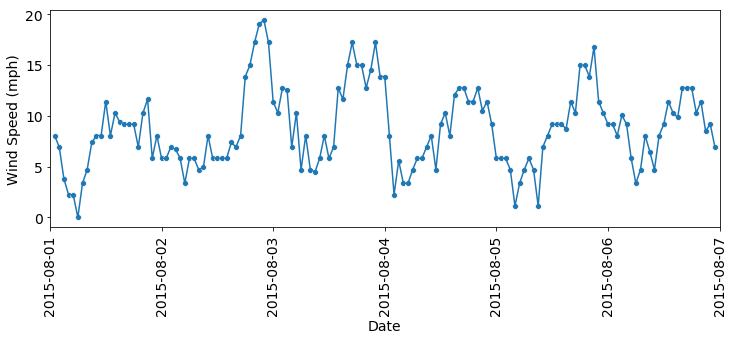

In [13]:
# visualize hourly wind speed at station n
stn = '710630'
start_date  = dt.datetime(year, 8, 1)
end_date = dt.datetime(year, 8, 7)
f,ax = plt.subplots(figsize=(12,4))
tmp_wthr_df = wthr_df.loc[
    (wthr_df['datetime']>start_date) & 
    (wthr_df['datetime']<end_date) & 
    (wthr_df['station_id']==stn)]
sns.scatterplot(x='datetime', y='wind_speed', data=tmp_wthr_df)
sns.lineplot(x='datetime', y='wind_speed', data=tmp_wthr_df)
ax.set_xlim([start_date,end_date])
plt.xticks(rotation=90)
ax.set_xlabel('Date')
ax.set_ylabel('Wind Speed (mph)')
plt.show();

In [14]:
# At this point we've got two pieces of information - write them to csv
#    (1) meta_df = Station location (and other metadata)
#    (2) wthr_df = Station weather conditions

meta_df.to_csv('compiled_wind_wthr_station_metadata_' + str(year) + '.csv')
wthr_df.to_csv('compiled_wind_speed_data_' + str(year) + '.csv')